In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# --- Veri Yükleme ve Ön İşleme ---
df = pd.read_excel('final_dataset_modified.xlsx')

# Tarih sütunundan yıl, ay ve gün bilgilerini çıkarıp yeni sütunlar ekleyelim
if 'Tarih' in df.columns:
    df['Tarih'] = pd.to_datetime(df['Tarih'], errors='coerce')
    df['Yıl'] = df['Tarih'].dt.year
    df['Ay'] = df['Tarih'].dt.month
    df['Gün'] = df['Tarih'].dt.day
else:
    print("Tarih sütunu bulunamadı!")

# Modelde kullanmayacağımız sütunlar: 'Seli', 'mccinfo' ve artık 'Tarih' (zaten yıl, ay, gün olarak eklendi)
drop_columns = ["Seli", "mccinfo", "Tarih"]
df_preprocessed = df.drop(columns=drop_columns)

# Sayısal veriler içeren fakat string olarak tutulmuş sütunları dönüştürelim.
cols_to_convert = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük"
]

def turkish_str_to_float(x):
    if isinstance(x, str):
        # Binlik ayıracını kaldır, ondalık ayracı noktaya çevir.
        x = x.replace('.', '').replace(',', '.')
    try:
        return float(x)
    except:
        return np.nan

for col in cols_to_convert:
    df_preprocessed[col] = df_preprocessed[col].apply(turkish_str_to_float)

# Kategorik değişkenler: "Şehir" ve "İlçe" sütunlarını one-hot encoding ile dönüştürelim.
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["Şehir", "İlçe"], drop_first=True)

# Hedef ve özelliklerin ayrılması
target_col = "Tek Çekim Komisyon Oranı (Güncel)"
X = df_preprocessed.drop(columns=[target_col])
y = df_preprocessed[target_col]

In [2]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'feature_selection__k': [8, 10, 'all'],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

kf_outer = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf_outer, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

print("En iyi hiperparametreler:", grid_search.best_params_)
print("En iyi R2 skoru (GridSearchCV ortalama): {:.4f}".format(grid_search.best_score_))

best_pipeline = grid_search.best_estimator_

fold_mae = []
fold_mape = []
fold_r2 = []
all_y_true = np.array([])
all_y_pred = np.array([])

fold_idx = 1
kf_manual = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf_manual.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    mae_fold = mean_absolute_error(y_test, y_pred)
    mape_fold = mean_absolute_percentage_error(y_test, y_pred)
    r2_fold = r2_score(y_test, y_pred)
    
    fold_mae.append(mae_fold)
    fold_mape.append(mape_fold)
    fold_r2.append(r2_fold)
    
    print(f"Fold {fold_idx} - MAE: {mae_fold:.4f}, MAPE: {mape_fold:.4f}, R2: {r2_fold:.4f}")
    fold_idx += 1
    
    all_y_true = np.concatenate([all_y_true, y_test.values])
    all_y_pred = np.concatenate([all_y_pred, y_pred])
    
print("\nOrtalama Değerlendirme Metrikleri:")
print(f"MAE: {np.mean(fold_mae):.4f}")
print(f"MAPE: {np.mean(fold_mape):.4f}")
print(f"R2: {np.mean(fold_r2):.4f}")


Fitting 10 folds for each of 324 candidates, totalling 3240 fits
En iyi hiperparametreler: {'feature_selection__k': 8, 'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.8}
En iyi R2 skoru (GridSearchCV ortalama): 0.6831
Fold 1 - MAE: 0.2385, MAPE: 0.0543, R2: 0.7185
Fold 2 - MAE: 0.3130, MAPE: 0.0901, R2: 0.5959
Fold 3 - MAE: 0.3535, MAPE: 0.0943, R2: 0.4173
Fold 4 - MAE: 0.2711, MAPE: 0.0904, R2: 0.7436
Fold 5 - MAE: 0.2727, MAPE: 0.0717, R2: 0.7704
Fold 6 - MAE: 0.2518, MAPE: 0.0594, R2: 0.7330
Fold 7 - MAE: 0.2111, MAPE: 0.0485, R2: 0.7447
Fold 8 - MAE: 0.2477, MAPE: 0.0575, R2: 0.7670
Fold 9 - MAE: 0.2637, MAPE: 0.0623, R2: 0.6121
Fold 10 - MAE: 0.2629, MAPE: 0.0577, R2: 0.7280

Ortalama Değerlendirme Metrikleri:
MAE: 0.2686
MAPE: 0.0686
R2: 0.6831


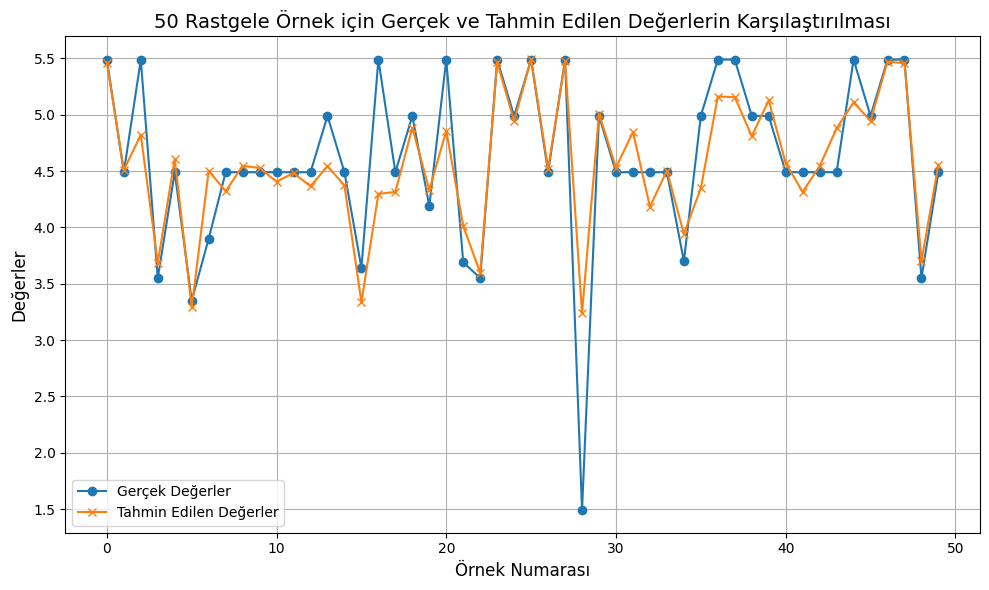

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Rastgele 50 örnek seçmek için indexleri belirleyelim.
np.random.seed(42)  # Tekrar üretilebilir sonuçlar için
total_samples = len(all_y_true)
random_indices = np.random.choice(total_samples, size=50, replace=False)

# Seçilen örnekler için gerçek ve tahmin edilen değerleri alalım.
sample_true = all_y_true[random_indices]
sample_pred = all_y_pred[random_indices]

# Örnek numarasını x ekseni için yeniden oluşturuyoruz (0'dan 49'a kadar).
sample_index = range(len(sample_true))

# Grafik çizimi:
plt.figure(figsize=(10, 6))
plt.plot(sample_index, sample_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=6)
plt.plot(sample_index, sample_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=6)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("50 Rastgele Örnek için Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

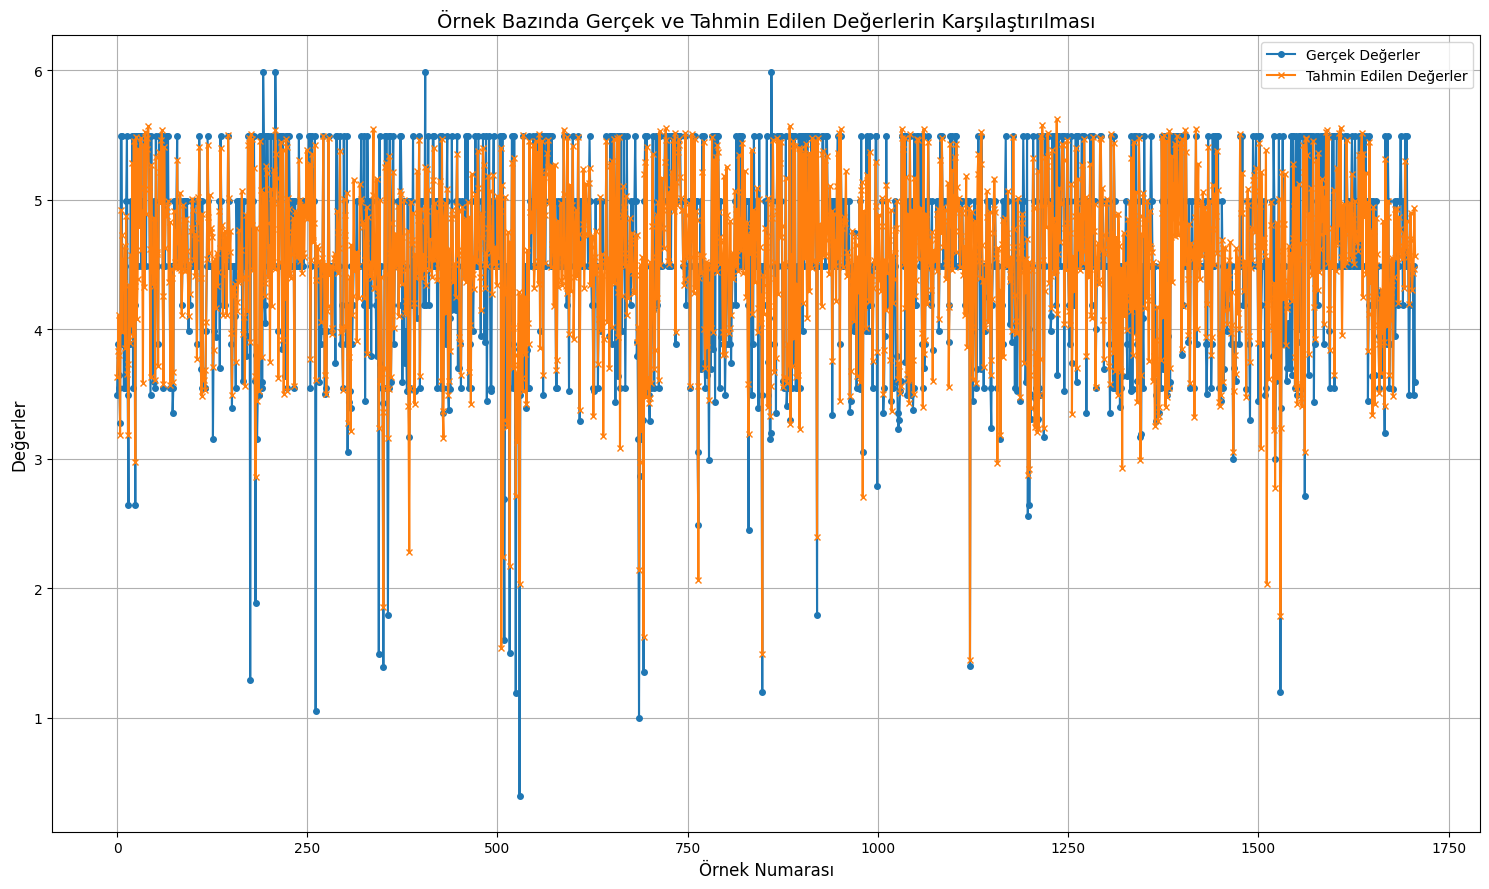

In [5]:
# --- Tahmin ve Gerçek Değerlerin Grafiksel Gösterimi (Örnek Bazında) ---
plt.figure(figsize=(15,9), dpi=100)
# Örnek numarası x ekseninde
sample_index = range(len(all_y_true))

# Gerçek değerler ve tahmin edilen değerleri çiziyoruz.
plt.plot(sample_index, all_y_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=4)
plt.plot(sample_index, all_y_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=4)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("Örnek Bazında Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()